In [1]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd

In [2]:
TRAIN_DATASET_PATH = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset'
TEST_DATASET_PATH = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset'


In [3]:
# models to compare 
available_models = {
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    # 'resnet152': models.resnet152,
    'resnext50_32x4d': models.resnext50_32x4d,
    'resnext101_32x8d': models.resnext101_32x8d,
    'wide_resnet50_2': models.wide_resnet50_2,
    'wide_resnet101_2': models.wide_resnet101_2,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'squeezenet1_1': models.squeezenet1_1,
    'densenet121': models.densenet121,
    'densenet169': models.densenet169,
    # 'densenet201': models.densenet201,
}

In [47]:
# create csv for the trichome dataset
class_names = []
for folder_name in os.listdir(TEST_DATASET_PATH):
    class_names.append(folder_name)
    
print(f"classes names:\n {class_names}")

image_paths = []
labels = []

for i in range(len(class_names)):
    class_name = class_names[i]
    image_names = os.listdir(f'{TEST_DATASET_PATH}/{class_name}')
    for image_name in image_names:
        image_path = f'{TEST_DATASET_PATH}/{class_name}/{image_name}'
        image_paths.append(image_path)
        labels.append(i)
        
        
df = pd.DataFrame(
    {
        'name': image_paths,
        'label': labels
    }
)

# if you want to save the to csv
# df.to_csv(
#     path_or_buf=f'{TRAIN_DATASET_PATH}/labels.csv',
#     index=False
# )

df.head()

In [53]:
# dist of the df data
df['label'].value_counts()

label
1    232
0    216
2     77
Name: count, dtype: int64

## Images Transformation Experiment
I want to compare the results when performing transformations like resize or color shifting for the images to see if I can get better results.
I will use a slim model to run the comparisons faster.

In [3]:
# model and metrics to compare
model_name = 'resnet34'
precision_macro = Precision(average='macro')
recall_macro = Recall(average='macro')
precision_micro = Precision(average='micro')
recall_micro = RecallMulti(average='micro')
roc_auc = RocAuc()


Raw dataloader

In [41]:
# create raw dataloader
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),
    bs=16,
    valid_pct=0.25
)

# if you want to see a sample of the data
# dls.show_batch()

In [44]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.459068,1.174221,0.427788,0.545757,0.550889,0.709838,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.084724,0.903926,0.341865,0.646656,0.642280,0.782210,00:04
1,0.907598,0.858765,0.332724,0.670691,0.647670,0.805444,00:04
2,0.745361,0.901603,0.338208,0.652682,0.645580,0.809109,00:04
3,0.650743,0.904548,0.323583,0.678016,0.645909,0.815037,00:04
4,0.645943,0.946854,0.347349,0.660784,0.638756,0.814700,00:04
5,0.545256,0.977793,0.323583,0.690069,0.638763,0.811875,00:04
6,0.497936,0.930665,0.356490,0.644886,0.607149,0.804449,00:04
7,0.414045,1.040586,0.334552,0.693488,0.643640,0.804074,00:04
8,0.342403,0.902106,0.325411,0.699959,0.614227,0.825781,00:04
9,0.311198,0.995935,0.319927,0.697767,0.622994,0.815269,00:04


Resize the Image to 128 with padding

In [4]:
import PIL

# Custom transform
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

# DataLoaders with custom transform
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(128),  # Adjust size as needed
    batch_tfms=aug_transforms(size=128),  # Apply data augmentation
    bs=16,
    valid_pct=0.25
)


# if you want to see a sample of the data
# dls.show_batch()

In [46]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.585254,1.227656,0.427788,0.563135,0.547723,0.734548,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.231721,0.874349,0.343693,0.636860,0.661927,0.792645,00:06
1,1.043655,0.865813,0.367459,0.622273,0.610897,0.798102,00:05
2,0.961187,0.855111,0.371115,0.629846,0.613344,0.799246,00:05
3,0.961301,0.890444,0.356490,0.661711,0.662150,0.795200,00:05
4,0.869433,0.877300,0.345521,0.660604,0.648854,0.801853,00:05
5,0.766256,0.695348,0.343693,0.705397,0.632298,0.836058,00:05
6,0.701299,0.791918,0.352834,0.704706,0.594252,0.814234,00:05
7,0.659042,0.798436,0.338208,0.641133,0.662409,0.831156,00:05
8,0.631873,0.699159,0.305302,0.699513,0.689909,0.849819,00:05
9,0.593867,0.715662,0.296161,0.690573,0.696598,0.843808,00:05


Convert the images to HSV

In [5]:
# Custom Transform to HSV using fastai's rgb2hsv
class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)
    
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),  # Resize before applying HSV transform
    batch_tfms=[RGB2HSV(), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
# dls.show_batch()


In [48]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.543482,1.053026,0.407678,0.552505,0.584303,0.758932,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.230895,0.855508,0.347349,0.645093,0.658531,0.791309,00:05
1,1.119144,0.803274,0.325411,0.688834,0.669267,0.807718,00:05
2,0.963601,0.752917,0.299817,0.704776,0.687470,0.833186,00:05
3,0.930227,0.686148,0.312614,0.691036,0.715819,0.864145,00:05
4,0.842901,0.734984,0.299817,0.701633,0.708033,0.840069,00:05
5,0.770539,0.672049,0.307130,0.735780,0.645989,0.848442,00:05
6,0.702882,0.678054,0.261426,0.751877,0.719858,0.863620,00:05
7,0.702857,0.672966,0.283364,0.723510,0.706803,0.852130,00:05
8,0.634815,0.634992,0.307130,0.707003,0.673530,0.864418,00:05
9,0.581727,0.673483,0.272395,0.741121,0.742084,0.874019,00:05


Normalize the images pixels

In [49]:
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),  # Resize before applying HSV transform
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
# dls.show_batch()


In [50]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.732388,1.104942,0.389397,0.567709,0.611454,0.755376,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.261801,0.848266,0.321755,0.642124,0.676323,0.809954,00:05
1,1.109568,0.818226,0.349177,0.628893,0.675801,0.822057,00:06
2,0.964629,0.776504,0.338208,0.631468,0.661511,0.831591,00:06
3,0.932905,0.765294,0.321755,0.633548,0.657773,0.837569,00:05
4,0.872124,0.685920,0.299817,0.696263,0.672213,0.844776,00:06
5,0.840126,0.789051,0.323583,0.642546,0.717136,0.829740,00:06
6,0.731988,0.640600,0.285192,0.722483,0.694947,0.858040,00:07
7,0.687337,0.709821,0.303474,0.681538,0.704702,0.859539,00:08
8,0.654730,0.630237,0.308958,0.687002,0.679414,0.861265,00:06
9,0.606821,0.749408,0.314442,0.652629,0.714622,0.857255,00:05


Brightness and Contrast Adjustments

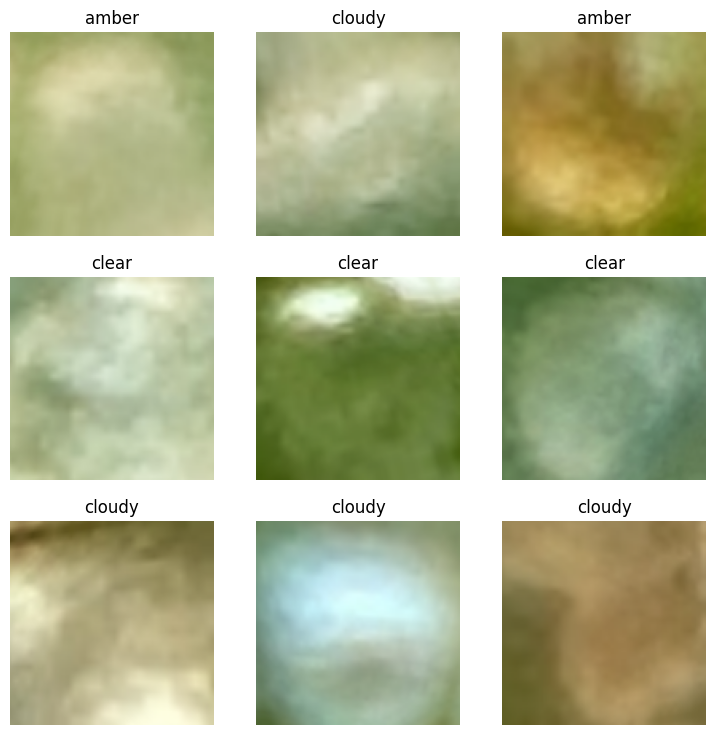

In [53]:
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128), 
    batch_tfms=[Brightness(max_lighting=0.2, p=0.75), Contrast(max_lighting=0.2, p=0.75), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()


In [52]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.604066,1.138211,0.382084,0.613353,0.626446,0.765438,00:06


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.244024,0.883623,0.356490,0.655182,0.648677,0.803721,00:06
1,1.108567,0.823120,0.330896,0.656467,0.690912,0.821352,00:06
2,0.974461,0.786989,0.319927,0.674209,0.682375,0.827640,00:07
3,0.990939,0.815781,0.307130,0.694943,0.694226,0.823158,00:07
4,0.886123,0.688135,0.310786,0.686382,0.674465,0.846319,00:06
5,0.804609,0.694007,0.319927,0.681322,0.701187,0.844205,00:06
6,0.742754,0.722755,0.279707,0.716032,0.715185,0.867318,00:06
7,0.680805,0.764495,0.323583,0.699638,0.689597,0.835456,00:07
8,0.668954,0.638936,0.305302,0.696729,0.728653,0.863100,00:07
9,0.633175,0.606152,0.277879,0.722525,0.734931,0.875443,00:06


Combined Transformations

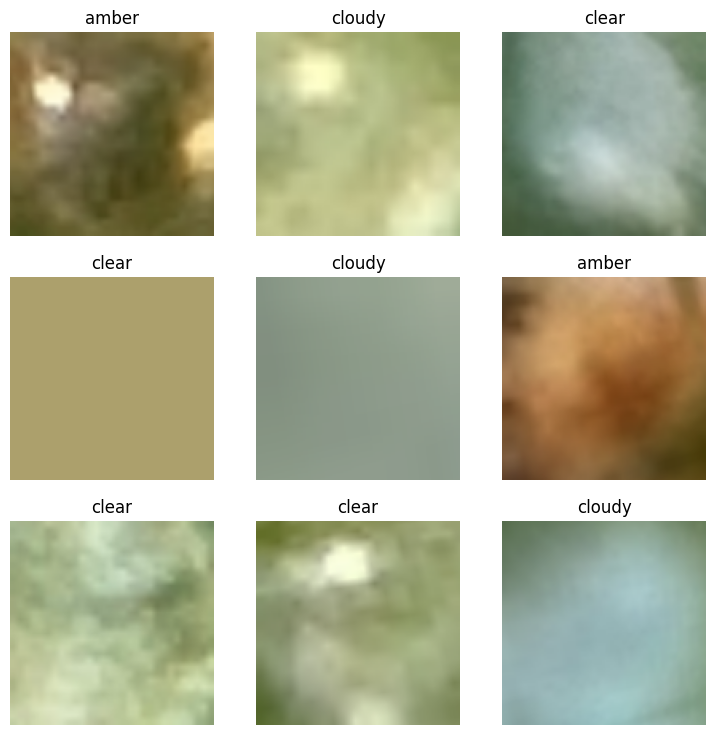

In [55]:
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(size=128),  # Resize and HSV transform
    batch_tfms=[
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()

In [56]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.545772,1.179755,0.391225,0.575086,0.623426,0.763160,00:05


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.172613,0.917406,0.354662,0.607664,0.641910,0.819787,00:05
1,1.123695,0.836722,0.332724,0.645917,0.637336,0.830438,00:06
2,0.997973,0.740655,0.307130,0.674299,0.675552,0.844593,00:06
3,0.978702,0.740064,0.329068,0.673903,0.676513,0.844343,00:05
4,0.925984,0.777038,0.303474,0.680224,0.706087,0.849066,00:06
5,0.813459,0.694614,0.279707,0.729323,0.697065,0.859209,00:06
6,0.754030,0.670959,0.288848,0.724385,0.704108,0.851680,00:06
7,0.736590,0.633308,0.283364,0.714538,0.690149,0.874171,00:06
8,0.701513,0.634199,0.297989,0.728288,0.676351,0.864213,00:06
9,0.636530,0.582150,0.274223,0.765461,0.707068,0.883462,00:06


In [73]:
model_saving_path = '/home/etaylor/code_projects/thesis/checkpoints/image_classification_models'
model_checkpoint = f'{model_saving_path}/{model_name}.pkl'
model.export(model_checkpoint)

### Evaluate the Model

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


item_tfms=custom_transform(size=128),  # Resize and HSV transform
batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

# Create the test DataLoader with the same transformations
test_dl = dls.test_dl(get_image_files(TEST_DATASET_PATH), with_labels=True, 
                    item_tfms=item_tfms, batch_tfms=batch_tfms)


# Evaluate on the test set
preds, targs = model.get_preds(dl=test_dl)


if targs is not None:
    pred_classes = preds.argmax(dim=1).numpy()
    true_classes = targs.numpy()

    precision = precision_score(true_classes, pred_classes, average='macro')
    recall = recall_score(true_classes, pred_classes, average='macro')
    accuracy = accuracy_score(true_classes, pred_classes)
else:
    precision = recall = accuracy = None

results = {
    'model': model_name,
    'precision': precision,
    'recall': recall,
    'accuracy': accuracy
}

results

### Compare Different Models
In this section I will compare different Image classification models with the datasets created.

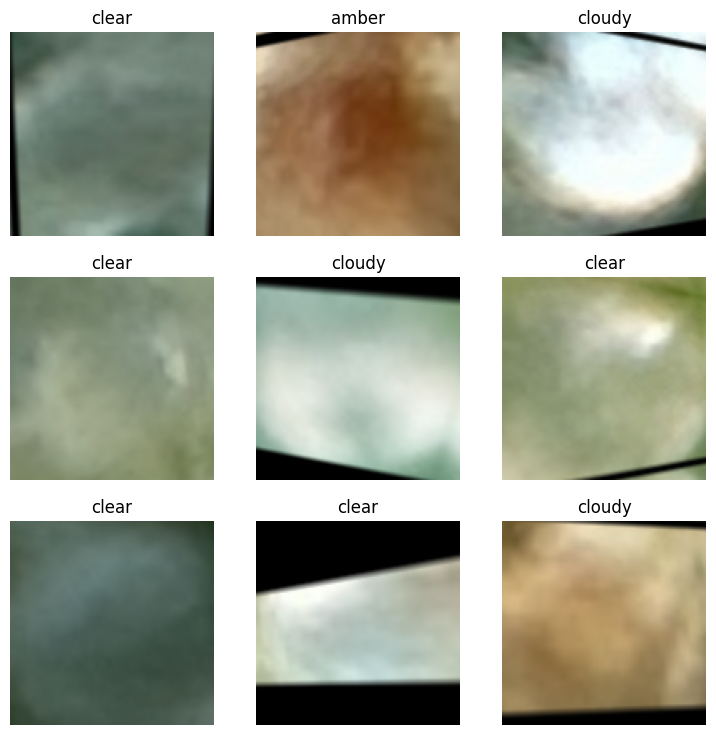

In [12]:
# lets bring the models and datasets 
available_models = {
    'alexnet': models.alexnet,
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    'resnet152': models.resnet152,
    'resnext50_32x4d': models.resnext50_32x4d,
    'resnext101_32x8d': models.resnext101_32x8d,
    'wide_resnet50_2': models.wide_resnet50_2,
    'wide_resnet101_2': models.wide_resnet101_2,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'squeezenet1_1': models.squeezenet1_1,
    'densenet121': models.densenet121,
    'densenet169': models.densenet169,
    'densenet201': models.densenet201,
}

dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(size=128),
    batch_tfms=[
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()

In [14]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()

item_tfms=custom_transform(size=128),  # Resize and HSV transform
batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

#Iterate over each model and train, then evaluate on the test set and save the results
results = []

for model_name, model_fn in available_models.items():
    print(f"Training model: {model_name}")
    
    model = vision_learner(
        dls=dls,
        arch=model_fn,
        metrics=[error_rate, precision_macro_fastai, recall_macro_fastai, roc_auc]
    )

    model.fine_tune(
        epochs=25
    )

    # Create the test DataLoader with the same transformations
    test_dl = dls.test_dl(get_image_files(TEST_DATASET_PATH), with_labels=True, 
                        item_tfms=item_tfms, batch_tfms=batch_tfms)

    # Evaluate on the test set
    preds, targs = model.get_preds(dl=test_dl)

    if targs is not None:
        pred_classes = preds.argmax(dim=1).numpy()
        true_classes = targs.numpy()

        precision = precision_score(true_classes, pred_classes, average='micro')
        recall = recall_score(true_classes, pred_classes, average='micro')
        
        # calc macro precision and recall
        precision_macro = precision_score(true_classes, pred_classes, average='macro')
        recall_macro = recall_score(true_classes, pred_classes, average='macro')
        
        accuracy = accuracy_score(true_classes, pred_classes)
        conf_matrix = confusion_matrix(true_classes, pred_classes)
        
        # Calculate precision and recall for each class
        precision_per_class = precision_score(true_classes, pred_classes, average=None)
        recall_per_class = recall_score(true_classes, pred_classes, average=None)
    else:
        precision_per_class = recall_per_class = precision = recall = accuracy = roc_auc = conf_matrix = None

    results.append({
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'pred_classes': pred_classes,
        'true_classes': true_classes
        
    })
    
    print(f"Results for model {model_name}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Precision Macro: {precision_macro}")
    print(f"Recall Macro: {recall_macro}")
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision per Class: {precision_per_class}")
    print(f"Recall per Class: {recall_per_class}")
    print("\n\n")
    print("\n\n")

Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.460655,0.918503,0.372943,0.588443,0.582970,0.763237,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.161089,0.842563,0.378428,0.604840,0.586949,0.798634,00:03
1,1.055935,0.770015,0.343693,0.661405,0.587567,0.808695,00:03
2,1.021882,0.815459,0.358318,0.628372,0.628466,0.810203,00:03
3,0.917054,0.774607,0.329068,0.668716,0.641501,0.815670,00:03
4,0.854940,0.743651,0.349177,0.667460,0.649070,0.828631,00:03
5,0.800258,0.676418,0.308958,0.708858,0.636472,0.844050,00:03
6,0.783033,0.695154,0.321755,0.683466,0.655073,0.840696,00:03
7,0.726486,0.695753,0.303474,0.693398,0.671012,0.836007,00:03
8,0.708545,0.702820,0.325411,0.693725,0.620843,0.833162,00:03
9,0.676214,0.675399,0.329068,0.675657,0.644209,0.847804,00:03


Results for model alexnet:
Precision: 0.7371428571428571
Recall: 0.7371428571428571
Precision Macro: 0.7563211258791966
Recall Macro: 0.7579710625687636
Accuracy: 0.7371428571428571
Confusion Matrix:
[[ 65   2  10]
 [  8 131  77]
 [ 10  31 191]]
Precision per Class: [0.78313253 0.79878049 0.68705036]
Recall per Class: [0.84415584 0.60648148 0.82327586]






Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.491587,1.137555,0.435101,0.529819,0.553113,0.717792,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.270176,0.934228,0.407678,0.554898,0.559793,0.765746,00:05
1,1.143970,0.854174,0.378428,0.618330,0.567750,0.779224,00:05
2,0.986765,1.008079,0.361974,0.660467,0.606834,0.779915,00:05
3,0.969187,0.843814,0.349177,0.686059,0.600444,0.784555,00:05
4,0.923654,0.767211,0.356490,0.701115,0.606724,0.788504,00:05
5,0.826403,0.819028,0.365631,0.623847,0.642653,0.804875,00:05
6,0.749346,0.742633,0.312614,0.711796,0.640543,0.826852,00:05
7,0.702664,0.726417,0.305302,0.721444,0.676892,0.849057,00:05
8,0.663747,0.755621,0.312614,0.683203,0.701065,0.844779,00:05
9,0.663375,0.757642,0.318099,0.692438,0.679341,0.830273,00:05


Results for model resnet34:
Precision: 0.699047619047619
Recall: 0.699047619047619
Precision Macro: 0.7313651261019682
Recall Macro: 0.7261303511303511
Accuracy: 0.699047619047619
Confusion Matrix:
[[ 64   3  10]
 [  5 129  82]
 [  8  50 174]]
Precision per Class: [0.83116883 0.70879121 0.65413534]
Recall per Class: [0.83116883 0.59722222 0.75      ]






Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.770941,1.590040,0.460695,0.503299,0.546935,0.719487,00:06


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.231485,1.117805,0.404022,0.584247,0.571438,0.743044,00:07
1,1.124363,0.969222,0.394881,0.596790,0.581089,0.763846,00:07
2,1.047148,0.910618,0.402194,0.610985,0.576198,0.760154,00:07
3,0.937628,0.896101,0.389397,0.604954,0.571258,0.770882,00:07
4,0.905108,0.867991,0.372943,0.681204,0.582946,0.775411,00:07
5,0.868883,0.778731,0.352834,0.688270,0.587347,0.800481,00:07
6,0.764026,0.750622,0.325411,0.711384,0.630829,0.808946,00:07
7,0.705803,0.784329,0.358318,0.685624,0.602496,0.808333,00:07
8,0.687356,0.680526,0.323583,0.695302,0.662573,0.848426,00:07
9,0.645903,0.707256,0.334552,0.727336,0.630827,0.823706,00:07


Results for model resnet50:
Precision: 0.6952380952380952
Recall: 0.6952380952380952
Precision Macro: 0.7648437022434135
Recall Macro: 0.7003505221896026
Accuracy: 0.6952380952380952
Confusion Matrix:
[[ 57   3  17]
 [  5 104 107]
 [  2  26 204]]
Precision per Class: [0.890625   0.78195489 0.62195122]
Recall per Class: [0.74025974 0.48148148 0.87931034]






Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.769117,1.465930,0.418647,0.553783,0.584580,0.737451,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.325327,1.096931,0.394881,0.580182,0.569603,0.736733,00:12
1,1.215793,0.978730,0.387569,0.584246,0.610837,0.754253,00:12
2,1.069928,0.920634,0.398537,0.596426,0.564655,0.769926,00:12
3,0.983163,0.894327,0.356490,0.656616,0.568544,0.762279,00:12
4,0.903033,0.835811,0.382084,0.612112,0.538719,0.787769,00:12
5,0.854994,0.777749,0.360146,0.638919,0.619451,0.796580,00:12
6,0.778537,0.763102,0.347349,0.646951,0.646212,0.809845,00:12
7,0.737955,0.732684,0.327239,0.701505,0.640941,0.820133,00:12
8,0.724512,0.707897,0.341865,0.674739,0.630071,0.828810,00:12
9,0.648080,0.740398,0.347349,0.692330,0.591299,0.828597,00:12


Results for model resnet101:
Precision: 0.7161904761904762
Recall: 0.7161904761904762
Precision Macro: 0.7798442343859099
Recall Macro: 0.716136460389334
Accuracy: 0.7161904761904762
Confusion Matrix:
[[ 56   6  15]
 [  2 131  83]
 [  1  42 189]]
Precision per Class: [0.94915254 0.73184358 0.65853659]
Recall per Class: [0.72727273 0.60648148 0.81465517]






Training model: resnet152


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.870173,1.546040,0.508227,0.455271,0.481377,0.650090,00:12


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.373174,1.082347,0.424132,0.539345,0.537973,0.719193,00:17
1,1.174360,1.020082,0.444241,0.525465,0.508087,0.708601,00:17
2,1.078087,0.934678,0.404022,0.583795,0.556592,0.750573,00:17
3,1.000761,0.884206,0.387569,0.636010,0.568860,0.749135,00:17
4,0.928756,0.842412,0.391225,0.587814,0.588092,0.770679,00:17
5,0.820335,0.894825,0.416819,0.606342,0.543493,0.776254,00:17
6,0.780392,0.813048,0.371115,0.681261,0.542029,0.782806,00:17
7,0.707765,0.825947,0.371115,0.657716,0.585746,0.781366,00:17
8,0.674147,0.712357,0.336380,0.680014,0.615114,0.842597,00:17
9,0.636331,0.670291,0.318099,0.704907,0.644280,0.854335,00:17


Results for model resnet152:
Precision: 0.6723809523809524
Recall: 0.6723809523809524
Precision Macro: 0.7389259514863379
Recall Macro: 0.6745389029871789
Accuracy: 0.6723809523809524
Confusion Matrix:
[[ 54   1  22]
 [  3 105 108]
 [  6  32 194]]
Precision per Class: [0.85714286 0.76086957 0.59876543]
Recall per Class: [0.7012987  0.48611111 0.8362069 ]






Training model: resnext50_32x4d


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.748163,1.507305,0.457038,0.521301,0.519409,0.713130,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.250578,1.059028,0.427788,0.540391,0.574494,0.747668,00:11
1,1.051711,0.935012,0.389397,0.587414,0.603152,0.772640,00:11
2,1.016482,0.899762,0.407678,0.573102,0.558269,0.764421,00:11
3,0.936087,0.932775,0.413163,0.584977,0.559201,0.758106,00:11
4,0.871331,0.859924,0.382084,0.627142,0.569306,0.771423,00:11
5,0.805331,0.810152,0.396709,0.606432,0.556163,0.784179,00:11
6,0.778553,0.740805,0.361974,0.678178,0.582484,0.817855,00:11
7,0.719313,0.773283,0.382084,0.631698,0.569524,0.796472,00:11
8,0.695155,0.718459,0.354662,0.653410,0.592502,0.828873,00:11
9,0.690313,0.758009,0.349177,0.688512,0.622714,0.831356,00:11


Results for model resnext50_32x4d:
Precision: 0.7028571428571428
Recall: 0.7028571428571428
Precision Macro: 0.7403752275599773
Recall Macro: 0.7121827193666274
Accuracy: 0.7028571428571428
Confusion Matrix:
[[ 58   6  13]
 [  5 134  77]
 [  5  50 177]]
Precision per Class: [0.85294118 0.70526316 0.66292135]
Recall per Class: [0.75324675 0.62037037 0.76293103]






Training model: resnext101_32x8d


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.664491,1.375218,0.425960,0.558501,0.581623,0.724374,00:18


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.140047,0.954113,0.382084,0.645157,0.619770,0.770734,00:28
1,1.072953,0.907485,0.374771,0.660761,0.591002,0.781926,00:28
2,0.998951,0.829041,0.382084,0.641493,0.571700,0.777964,00:28
3,0.936451,0.848098,0.365631,0.627500,0.624978,0.784184,00:28
4,0.845253,0.790641,0.360146,0.671497,0.631517,0.810624,00:28
5,0.786151,0.767500,0.365631,0.680495,0.615088,0.806536,00:28
6,0.714141,0.795568,0.382084,0.651699,0.577141,0.801426,00:28
7,0.697830,0.717083,0.345521,0.711185,0.623599,0.825620,00:28
8,0.621795,0.706280,0.321755,0.719121,0.656475,0.844047,00:32
9,0.617668,0.686481,0.318099,0.713558,0.666525,0.849005,00:28


Results for model resnext101_32x8d:
Precision: 0.6876190476190476
Recall: 0.6876190476190476
Precision Macro: 0.7485371252242418
Recall Macro: 0.7016649804006126
Accuracy: 0.6876190476190476
Confusion Matrix:
[[ 59   3  15]
 [  4 116  96]
 [  2  44 186]]
Precision per Class: [0.90769231 0.71165644 0.62626263]
Recall per Class: [0.76623377 0.53703704 0.80172414]






Training model: wide_resnet50_2


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.863494,1.381028,0.446069,0.517682,0.519069,0.690103,00:07


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.240638,1.127932,0.449726,0.528809,0.538857,0.709097,00:12
1,1.115361,0.991472,0.427788,0.550359,0.546808,0.737831,00:12
2,1.005565,0.904363,0.438757,0.540174,0.510516,0.752871,00:12
3,0.983057,0.897190,0.394881,0.597528,0.546052,0.763081,00:12
4,0.895582,0.902202,0.382084,0.619048,0.574529,0.767879,00:12
5,0.854084,0.804180,0.387569,0.600153,0.580249,0.776992,00:12
6,0.792087,0.804556,0.383912,0.612915,0.602220,0.787983,00:12
7,0.754307,0.809059,0.372943,0.633958,0.606062,0.795702,00:12
8,0.754328,0.742067,0.340037,0.688162,0.599237,0.814288,00:12
9,0.700017,0.741591,0.374771,0.652935,0.603382,0.808957,00:12


Results for model wide_resnet50_2:
Precision: 0.6761904761904762
Recall: 0.6761904761904762
Precision Macro: 0.738682961958824
Recall Macro: 0.6648670614187856
Accuracy: 0.6761904761904762
Confusion Matrix:
[[ 49   5  23]
 [  3 123  90]
 [  3  46 183]]
Precision per Class: [0.89090909 0.70689655 0.61824324]
Recall per Class: [0.63636364 0.56944444 0.7887931 ]






Training model: wide_resnet101_2


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.872212,6.601451,0.482633,0.478038,0.505907,0.689138,00:14


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.269213,4.206591,0.404022,0.573240,0.586866,0.743079,00:20
1,1.042592,2.844680,0.383912,0.630736,0.563048,0.763268,00:20
2,1.005160,1.604763,0.393053,0.617625,0.570010,0.764585,00:20
3,0.917736,1.329444,0.389397,0.596146,0.574402,0.762634,00:20
4,0.917471,1.877985,0.416819,0.567910,0.505555,0.739951,00:20
5,0.846385,2.455086,0.422303,0.580640,0.577213,0.774914,00:20
6,0.779999,2.914088,0.363803,0.660202,0.561355,0.773325,00:20
7,0.744687,3.644416,0.383912,0.618834,0.589090,0.782572,00:20
8,0.705693,1.889663,0.345521,0.660981,0.588562,0.798122,00:20
9,0.662612,0.837375,0.354662,0.653542,0.611144,0.812982,00:20


Results for model wide_resnet101_2:
Precision: 0.68
Recall: 0.68
Precision Macro: 0.7194326741996234
Recall Macro: 0.6679534811718719
Accuracy: 0.68
Confusion Matrix:
[[ 49   7  21]
 [  7 125  84]
 [  4  45 183]]
Precision per Class: [0.81666667 0.70621469 0.63541667]
Recall per Class: [0.63636364 0.5787037  0.7887931 ]






Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.642945,1.433187,0.491773,0.496864,0.494444,0.697229,00:06


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.232867,0.938413,0.387569,0.585248,0.581772,0.782306,00:08
1,1.116180,0.830817,0.374771,0.619139,0.574971,0.805125,00:08
2,0.995202,0.813112,0.338208,0.655595,0.608010,0.815813,00:08
3,0.873079,0.816409,0.332724,0.682690,0.629831,0.822888,00:08
4,0.818637,0.742186,0.305302,0.720568,0.630998,0.848665,00:08
5,0.786861,0.731075,0.332724,0.671663,0.644919,0.838616,00:08
6,0.718208,0.763531,0.330896,0.670102,0.643053,0.818051,00:08
7,0.666499,0.716044,0.292505,0.720371,0.661531,0.846866,00:08
8,0.638468,0.690273,0.303474,0.722375,0.655802,0.846502,00:08
9,0.607882,0.675458,0.308958,0.715469,0.664448,0.862071,00:08


Results for model vgg16_bn:
Precision: 0.6685714285714286
Recall: 0.6685714285714286
Precision Macro: 0.723417673080161
Recall Macro: 0.669943827989805
Accuracy: 0.6685714285714286
Confusion Matrix:
[[ 53   8  16]
 [  4 116  96]
 [  4  46 182]]
Precision per Class: [0.86885246 0.68235294 0.61904762]
Recall per Class: [0.68831169 0.53703704 0.78448276]






Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.553133,1.178247,0.478976,0.499554,0.562672,0.702465,00:07


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.222786,0.967677,0.387569,0.593850,0.610184,0.765192,00:09
1,1.081102,0.957763,0.393053,0.661071,0.594239,0.792715,00:09
2,0.955737,0.905673,0.351005,0.678625,0.574866,0.801381,00:09
3,0.918828,0.861271,0.336380,0.686918,0.604741,0.802994,00:09
4,0.844962,0.798258,0.308958,0.738826,0.620078,0.819779,00:09
5,0.823575,0.720227,0.334552,0.669040,0.629110,0.825021,00:09
6,0.779338,0.651066,0.296161,0.730626,0.680013,0.858897,00:09
7,0.722007,0.740527,0.334552,0.698829,0.632592,0.827212,00:09
8,0.645909,0.799656,0.323583,0.720181,0.644462,0.828047,00:09
9,0.656503,0.652208,0.292505,0.736967,0.683438,0.863380,00:09


Results for model vgg19_bn:
Precision: 0.68
Recall: 0.68
Precision Macro: 0.7526075011412602
Recall Macro: 0.6814567403647863
Accuracy: 0.68
Confusion Matrix:
[[ 54   4  19]
 [  2 116  98]
 [  2  43 187]]
Precision per Class: [0.93103448 0.71165644 0.61513158]
Recall per Class: [0.7012987  0.53703704 0.80603448]






Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.469400,1.013157,0.380256,0.574771,0.593603,0.736495,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.106463,0.854174,0.345521,0.623255,0.628387,0.780240,00:04
1,1.059456,0.814241,0.354662,0.627290,0.629594,0.787828,00:04
2,1.049312,0.790978,0.352834,0.656463,0.614162,0.793699,00:04
3,1.020266,0.955744,0.389397,0.625444,0.576360,0.758960,00:04
4,0.937088,2.325938,0.416819,0.608842,0.586992,0.775210,00:04
5,0.875226,2.606474,0.376600,0.602254,0.571300,0.761981,00:04
6,0.806349,0.725212,0.358318,0.647458,0.669330,0.827012,00:04
7,0.799310,0.891009,0.371115,0.656002,0.592468,0.799754,00:04
8,0.832360,1.154577,0.510055,0.537095,0.490160,0.703076,00:04
9,0.805271,0.776732,0.382084,0.629118,0.595976,0.806088,00:04


Results for model squeezenet1_1:
Precision: 0.7066666666666667
Recall: 0.7066666666666667
Precision Macro: 0.7586308458541055
Recall Macro: 0.7053153317521134
Accuracy: 0.7066666666666667
Confusion Matrix:
[[ 55   4  18]
 [  3 124  89]
 [  5  35 192]]
Precision per Class: [0.87301587 0.7607362  0.64214047]
Recall per Class: [0.71428571 0.57407407 0.82758621]






Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.460381,1.108380,0.420475,0.551545,0.599358,0.757218,00:11


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.215453,0.888208,0.358318,0.637779,0.624888,0.802883,00:13
1,1.020558,0.785677,0.329068,0.691487,0.642154,0.815305,00:13
2,0.938140,0.823256,0.340037,0.662924,0.642833,0.820684,00:14
3,0.877119,0.760770,0.330896,0.667213,0.642400,0.823937,00:15
4,0.830158,0.728506,0.338208,0.674972,0.631319,0.832675,00:14
5,0.741305,0.727893,0.316271,0.726797,0.632887,0.826327,00:14
6,0.706092,0.693130,0.297989,0.749828,0.669185,0.846146,00:14
7,0.698079,0.726333,0.319927,0.675541,0.666554,0.848553,00:14
8,0.670226,0.680028,0.301645,0.705520,0.655895,0.851812,00:16
9,0.614612,0.665137,0.288848,0.744246,0.671774,0.862666,00:16


Results for model densenet121:
Precision: 0.6876190476190476
Recall: 0.6876190476190476
Precision Macro: 0.7573520364218038
Recall Macro: 0.7015585521332648
Accuracy: 0.6876190476190476
Confusion Matrix:
[[ 59   3  15]
 [  2 115  99]
 [  2  43 187]]
Precision per Class: [0.93650794 0.71428571 0.62126246]
Recall per Class: [0.76623377 0.53240741 0.80603448]






Training model: densenet169


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.682464,1.193570,0.429616,0.549653,0.590046,0.759018,00:15


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.135334,0.846085,0.354662,0.621316,0.637621,0.811206,00:18
1,0.959952,0.780394,0.327239,0.663155,0.662751,0.825989,00:18
2,0.966128,0.766293,0.349177,0.670487,0.645467,0.822739,00:18
3,0.893946,0.769925,0.332724,0.695146,0.644073,0.824914,00:20
4,0.793528,0.747047,0.323583,0.695585,0.660517,0.822023,00:18
5,0.798685,0.688640,0.318099,0.701881,0.668701,0.834865,00:18
6,0.696546,0.650216,0.296161,0.691374,0.704967,0.862383,00:23
7,0.681247,0.700984,0.314442,0.713183,0.656603,0.843136,00:24
8,0.643776,0.727943,0.303474,0.707722,0.690090,0.847451,00:24
9,0.591244,0.652590,0.287020,0.731127,0.677936,0.866113,00:24


Results for model densenet169:
Precision: 0.699047619047619
Recall: 0.699047619047619
Precision Macro: 0.7451956578632059
Recall Macro: 0.7074812161019057
Accuracy: 0.699047619047619
Confusion Matrix:
[[ 57   9  11]
 [  2 144  70]
 [  5  61 166]]
Precision per Class: [0.890625   0.6728972  0.67206478]
Recall per Class: [0.74025974 0.66666667 0.71551724]






Training model: densenet201


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.551077,1.326697,0.422303,0.551632,0.548923,0.720153,00:19


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.187258,0.990202,0.378428,0.605577,0.656176,0.797486,00:22
1,1.002673,0.795029,0.336380,0.675863,0.615695,0.814862,00:22
2,0.892490,0.751896,0.325411,0.697684,0.654259,0.827477,00:30
3,0.835471,0.773386,0.323583,0.692827,0.647944,0.827106,00:29
4,0.809033,0.777645,0.338208,0.696465,0.612894,0.812510,00:28
5,0.750330,0.693887,0.318099,0.704315,0.666550,0.850934,00:28
6,0.723788,0.815531,0.354662,0.708148,0.591293,0.810868,00:27
7,0.661646,0.872699,0.354662,0.709506,0.577849,0.789218,00:21
8,0.605502,0.684951,0.301645,0.748533,0.643853,0.856126,00:21
9,0.582120,0.730882,0.301645,0.752049,0.638219,0.845570,00:22


Results for model densenet201:
Precision: 0.7028571428571428
Recall: 0.7028571428571428
Precision Macro: 0.778396311291048
Recall Macro: 0.6989109762098268
Accuracy: 0.7028571428571428
Confusion Matrix:
[[ 54   4  19]
 [  2 118  96]
 [  1  34 197]]
Precision per Class: [0.94736842 0.75641026 0.63141026]
Recall per Class: [0.7012987  0.5462963  0.84913793]








In [15]:
results

[{'model': 'alexnet',
  'precision': 0.7371428571428571,
  'recall': 0.7371428571428571,
  'precision_macro': 0.7563211258791966,
  'recall_macro': 0.7579710625687636,
  'precision_per_class': array([0.78313253, 0.79878049, 0.68705036]),
  'recall_per_class': array([0.84415584, 0.60648148, 0.82327586]),
  'accuracy': 0.7371428571428571,
  'confusion_matrix': array([[ 65,   2,  10],
         [  8, 131,  77],
         [ 10,  31, 191]]),
  'pred_classes': array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2,
         2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
         0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
         1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 1, 0, 0, 1, 1,
         1, 1, 2, 1,

<Figure size 1400x800 with 0 Axes>

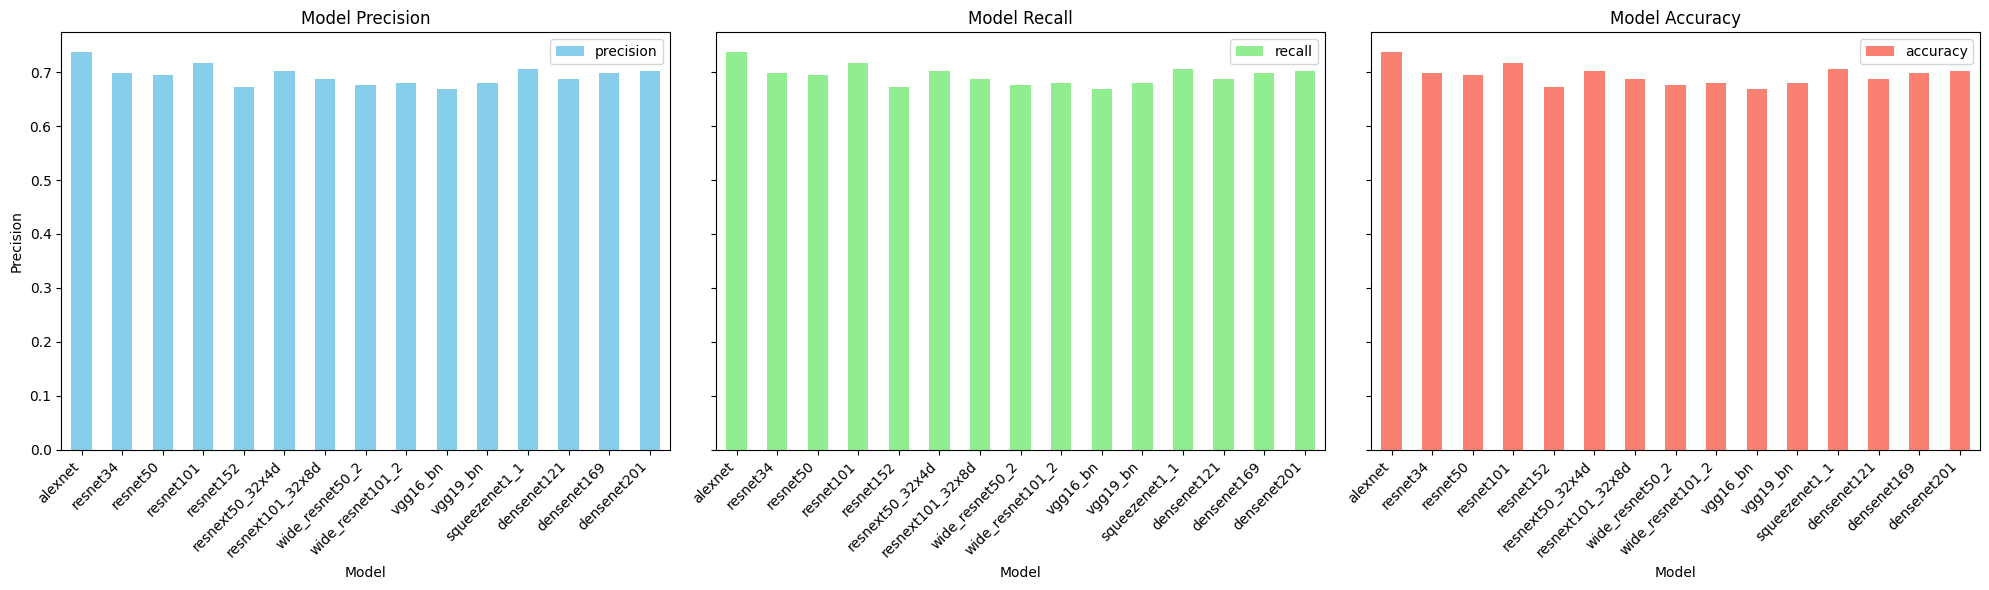

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results)


# Set the size of the plot
plt.figure(figsize=(14, 8))

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot Precision
df.plot(kind='bar', x='model', y='precision', ax=axes[0], color='skyblue')
axes[0].set_title('Model Precision')
axes[0].set_ylabel('Precision')

# Plot Recall
df.plot(kind='bar', x='model', y='recall', ax=axes[1], color='lightgreen')
axes[1].set_title('Model Recall')

# Plot Accuracy
df.plot(kind='bar', x='model', y='accuracy', ax=axes[2], color='salmon')
axes[2].set_title('Model Accuracy')

# Set common properties
for ax in axes:
    ax.set_xlabel('Model')
    ax.set_xticklabels(df['model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


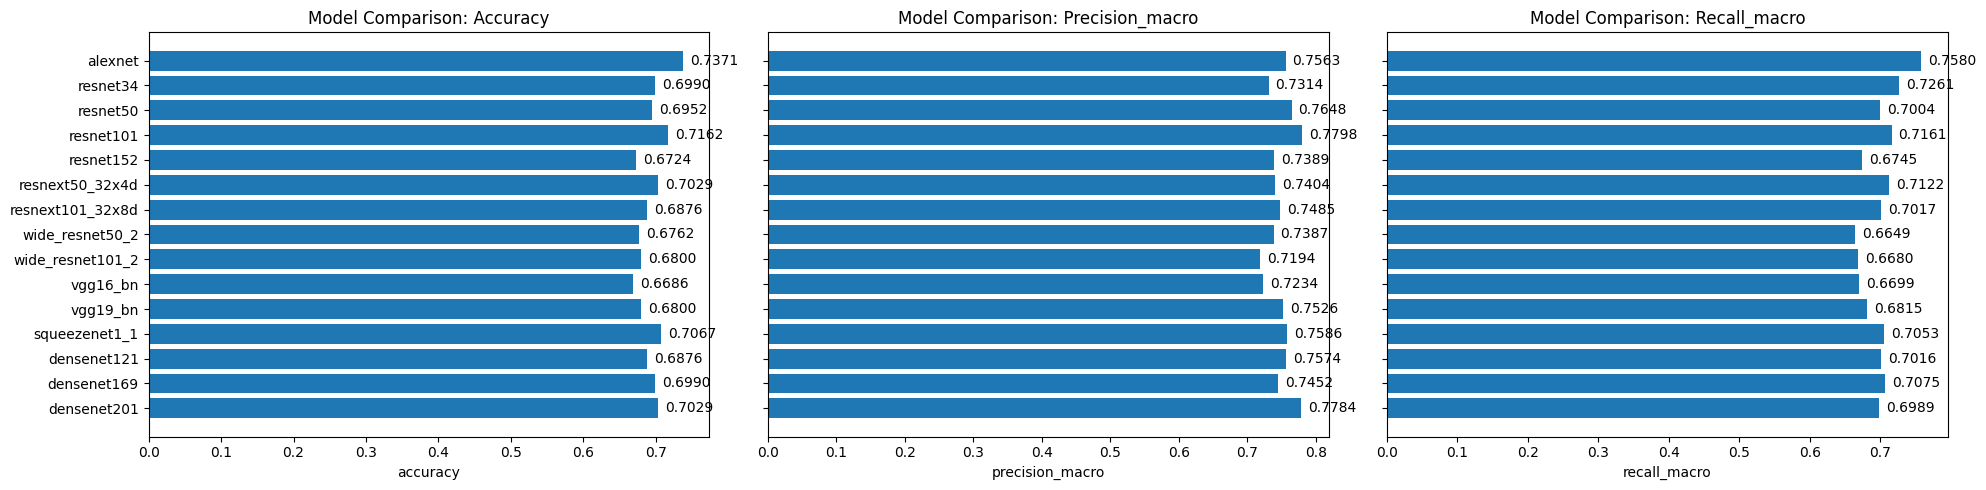

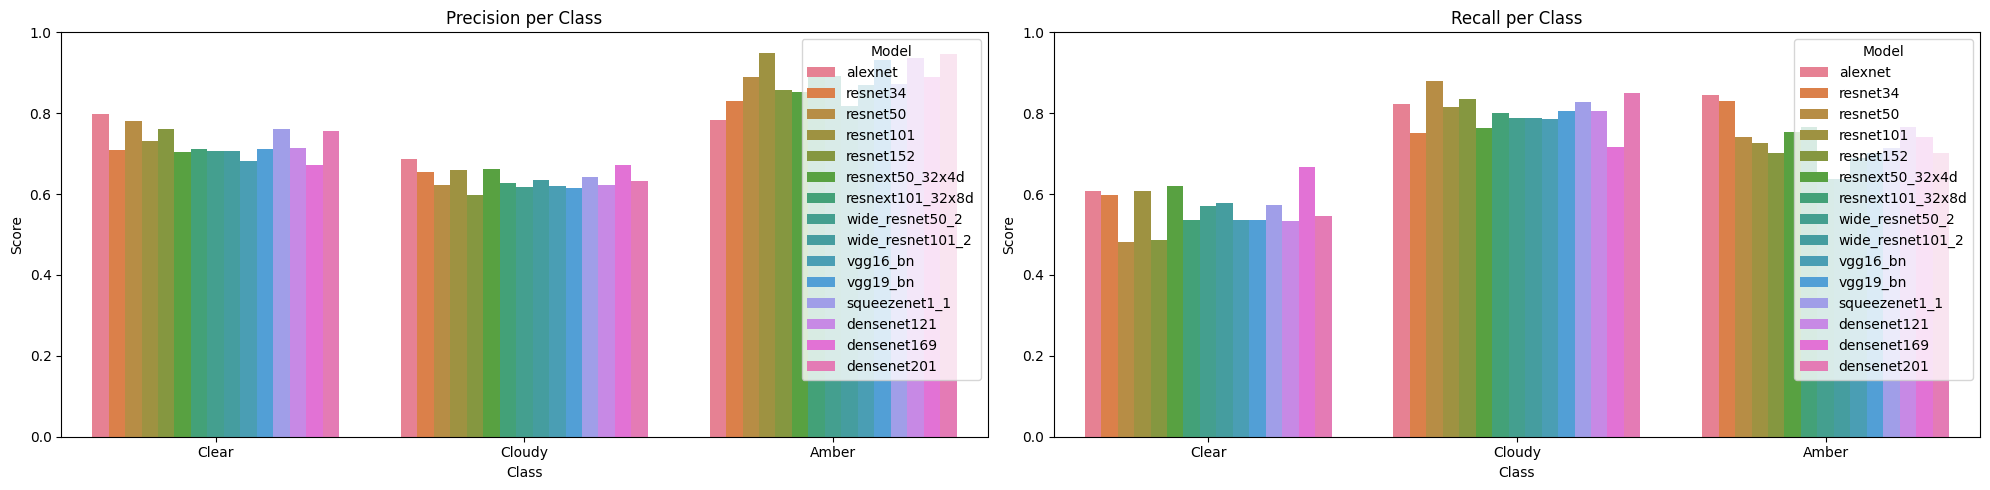

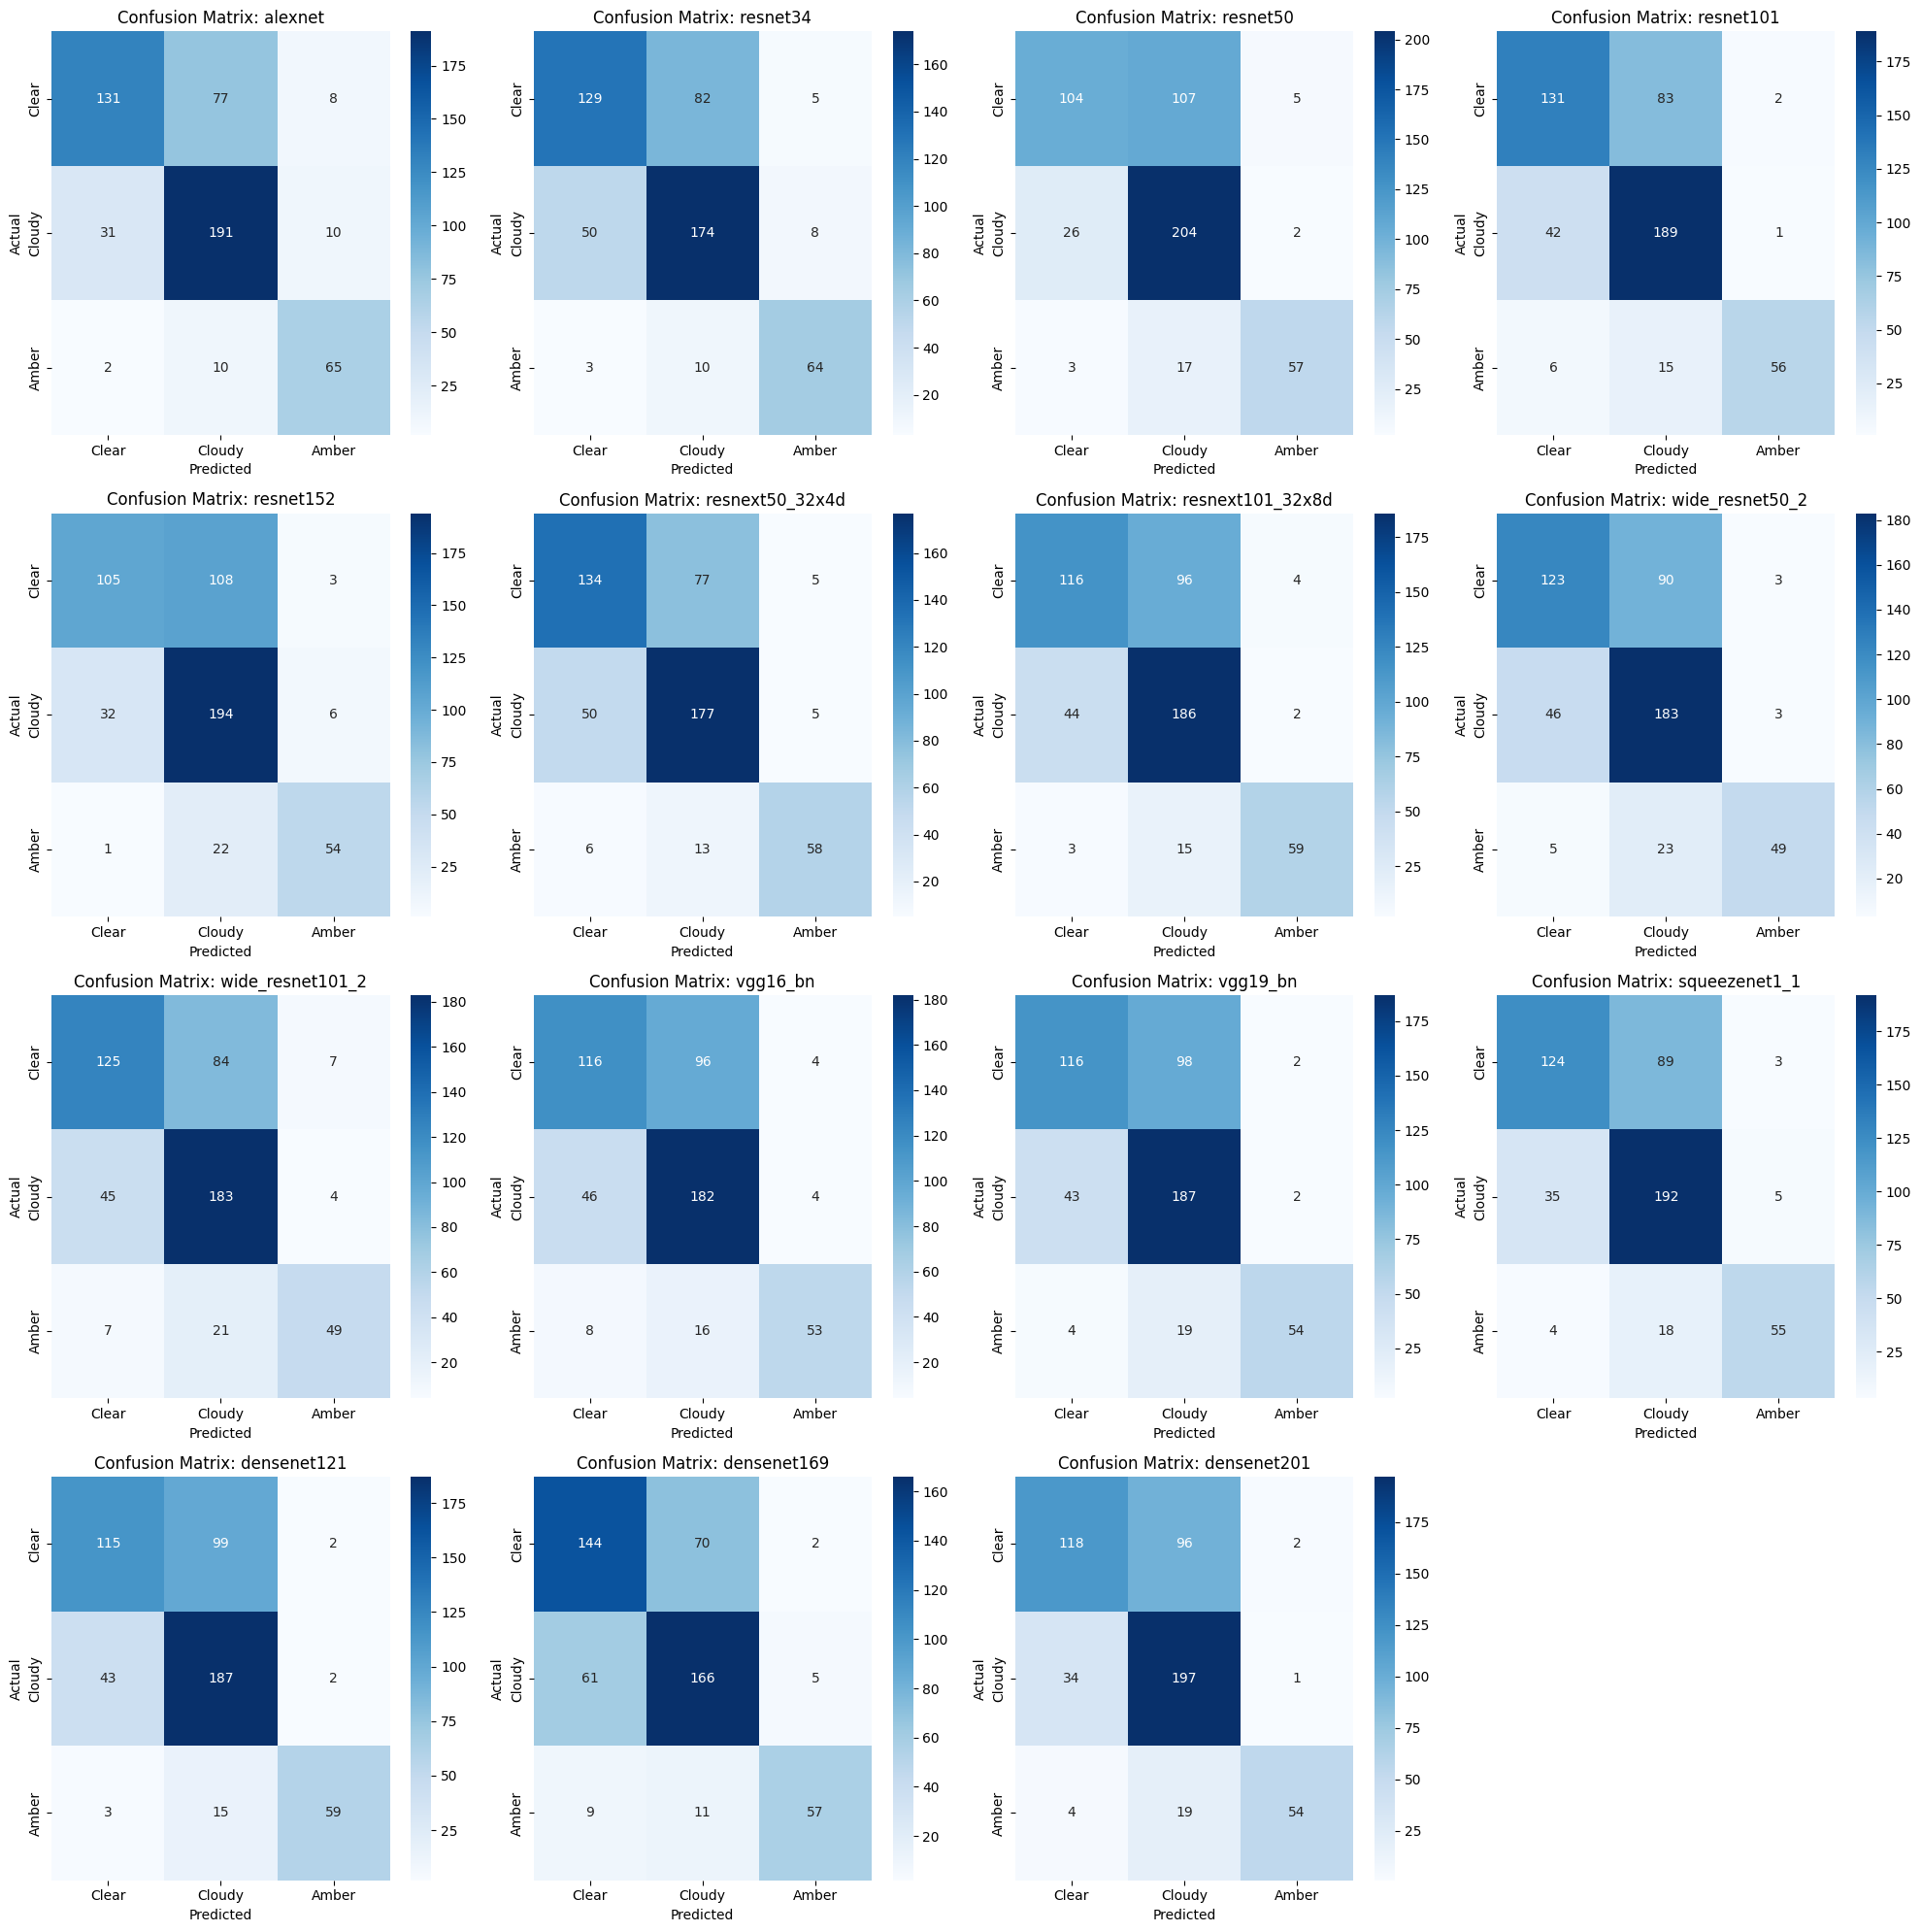

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Assuming results is your list of dictionaries containing model results

# Define the new order of classes
class_mapping = {0: 2, 1: 0, 2: 1}  # Mapping from old to new class indices
inverse_class_mapping = {v: k for k, v in class_mapping.items()}  # Inverse mapping

# Function to reorder classes
def reorder_classes(true_classes, pred_classes, mapping):
    true_classes_reordered = np.array([mapping[cls] for cls in true_classes])
    pred_classes_reordered = np.array([mapping[cls] for cls in pred_classes])
    return true_classes_reordered, pred_classes_reordered

# Function to reorder confusion matrix
def reorder_confusion_matrix(cm, mapping):
    cm_reordered = cm[np.ix_([mapping[i] for i in range(len(mapping))],
                             [mapping[i] for i in range(len(mapping))])]
    return cm_reordered

# Reorder classes and update results
for result in results:
    true_classes = result['true_classes']
    pred_classes = result['pred_classes']
    true_classes_reordered, pred_classes_reordered = reorder_classes(true_classes, pred_classes, class_mapping)
    result['true_classes_reordered'] = true_classes_reordered
    result['pred_classes_reordered'] = pred_classes_reordered
    result['confusion_matrix_reordered'] = reorder_confusion_matrix(result['confusion_matrix'], inverse_class_mapping)

# Function to calculate precision and recall for each class
def calculate_class_metrics(results):
    for result in results:
        true_classes = result['true_classes_reordered']
        pred_classes = result['pred_classes_reordered']

        result['precision_per_class'] = precision_score(true_classes, pred_classes, average=None)
        result['recall_per_class'] = recall_score(true_classes, pred_classes, average=None)

# Calculate class metrics
calculate_class_metrics(results)

# Extract metrics for plotting
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro"]
results_dict = {result['model']: result for result in results}

# Initialize plot for metrics
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metric_values = [results_dict[model][metric] for model in results_dict.keys()]
    models = list(results_dict.keys())
    y_pos = np.arange(len(models))

    axes[i].barh(y_pos, metric_values, align='center')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(models)
    axes[i].invert_yaxis()  # Invert y-axis to have the best model on top
    axes[i].set_xlabel(metric)
    axes[i].set_title(f'Model Comparison: {metric.capitalize()}')

    # Annotate bars with values
    for j in range(len(models)):
        axes[i].text(metric_values[j] + 0.01, y_pos[j], f'{metric_values[j]:.4f}', va='center')

plt.tight_layout()
plt.show()

# Plot precision and recall for each class
def plot_class_metrics(results):
    class_labels = ['Clear', 'Cloudy', 'Amber']

    precision_data = []
    recall_data = []
    for result in results:
        model_name = result['model']
        precision_per_class = result['precision_per_class']
        recall_per_class = result['recall_per_class']
        for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
            precision_data.append({'Model': model_name, 'Class': class_labels[i], 'Score': precision})
            recall_data.append({'Model': model_name, 'Class': class_labels[i], 'Score': recall})
    
    precision_df = pd.DataFrame(precision_data)
    recall_df = pd.DataFrame(recall_data)

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0])
    axes[0].set_title('Precision per Class')
    axes[0].set_ylim(0, 1)

    sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1])
    axes[1].set_title('Recall per Class')
    axes[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Plot all confusion matrices in a grid
def plot_confusion_matrices(results_dict):
    num_models = len(results_dict)
    num_cols = 4  # Number of columns for confusion matrix grid
    num_rows = (num_models + num_cols - 1) // num_cols  # Compute required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, (name, metrics) in enumerate(results_dict.items()):
        cm = metrics['confusion_matrix_reordered']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Clear', 'Cloudy', 'Amber'],
                    yticklabels=['Clear', 'Cloudy', 'Amber'])
        axes[i].set_title(f'Confusion Matrix: {name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the plotting functions
plot_class_metrics(results)
plot_confusion_matrices(results_dict)


In [ ]:
#TODO NEXT
"""
V - try to understand how can i improve the use of the dinov2 (for start it didnt recieve the best results)
V - compare more classifiers on the dinov2
- try more models that convert the images to embeddings and then with classifiers
- try to see if i can apply thresholds based on colors or other features to cluster or classify the trichomes
- try to see if i can apply some kind of clustering to the images and then classify them
- try to see if i can apply some kind of clustering to the embeddings and then classify them.
- check if i can do more transformations like i did in the time series course to the data in order to perform classification.
"""